<a href="https://colab.research.google.com/github/ayushgupt/ayushgupt.github.io/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [77]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!wget https://raw.githubusercontent.com/ayushgupt/ayushgupt.github.io/master/haarcascade_frontalface_alt.xml
!unzip dogImages.zip
!unzip lfw.zip

Archive:  lfw.zip
replace lfw/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [78]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


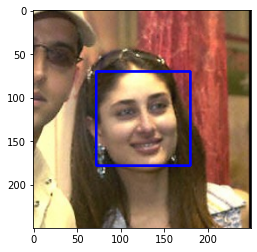

In [79]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell). 
As Seen below 98% of human images were correctly labelled to have a human face and 15% of dog images were incorrectly labelled to have a human face


In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

count_humans = 0 
count_dogs = 0

for file in human_files_short:
    if face_detector(file):
        count_humans += 1
        
for file in dog_files_short:
    if face_detector(file):
        count_dogs += 1

print("Number of Humans Images", len(human_files_short))
print("count_humans",count_humans)
print("Number of Dog Images", len(dog_files_short))
print("count_dogs",count_dogs)

Number of Humans Images 100
count_humans 98
Number of Dog Images 100
count_dogs 15


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [7]:
use_cuda

True

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [18]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    image = Image.open(img_path)

    transform_pipeline = transforms.Compose(
        [transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    img = transform_pipeline(image)
    if use_cuda:
        img = img.cuda()
    
    img_tensor = (img.unsqueeze(0))
      
    VGG16.eval()    
    with torch.no_grad():
        vgg_out = VGG16(img_tensor)
        index_pred = torch.argmax(vgg_out).item()
        
    VGG16.train()
    
    return index_pred # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    vgg_pred = VGG16_predict(img_path)

    if(vgg_pred<=268 and vgg_pred>=151):
        return True
    else:
        return False
    return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  As Seen below, 99% of dog images are correctly shown to have dog images and No Human image is incorrectly labelled to have a dog face.  This is a better face detector for dogs than the one in previous step which was for humans


In [20]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
count_humans = 0 
count_dogs = 0

for file in human_files_short:
    if dog_detector(file):
        count_humans += 1
        
for file in dog_files_short:
    if dog_detector(file):
        count_dogs += 1

print("Number of Humans Images", len(human_files_short))
print("count_humans",count_humans)
print("Number of Dog Images", len(dog_files_short))
print("count_dogs",count_dogs)

Number of Humans Images 100
count_humans 0
Number of Dog Images 100
count_dogs 99


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [60]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = 'dogImages/train'
test_dir = 'dogImages/test'
valid_dir = 'dogImages/valid'
train_transforms = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(15),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);
validTest_transforms = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);
testTest_transforms = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);


train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=validTest_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=testTest_transforms)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           num_workers=0, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=128, 
                                          num_workers=0, 
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=128, 
                                           num_workers=0, 
                                           shuffle=True)

loaders_scratch = dict(train=train_loader, test=test_loader, valid=valid_loader)

In [38]:
!ls dogImages

test  train  valid


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The above transformation randomly crop the image to 224x224 pixels, this is because VGG16 also has the same input size and seems to perform decently on various classification datasets, Also in the transfer learning part next, this makes it easy to compare the performance with "trained from scratch" model.

I did add Horizontal flipping as well as rotation upto 15 degrees, this reduces over-fitting and can be said to augment the dataset or randomize it a bit. It basically helps in generalization and making better predictions on new images.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [67]:
import torch.nn as nn
import torch.nn.functional as F

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25088, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, 133)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 25088)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I have tried to follow what are the standard practices followed in CNN architechtures as told in CS231n course by Stanford. So, I have inserted convolution layers at the start followed by Max Pooling and Finally some fully connected layers. Drop-out layers added help to reduce over-fitting and Max Pooling helps to down-sample to reduce the number of parameters we want to optimize. 


The First layer has 3 input channels because input images have R, G and B channel. The final layer has 133 output tensor owing to the 133 dog breed classes that we have to predict. In between, I have increased the channels number constantly as i read that these different channels correspond to different latent functions, like edge detection, other imagery features, etc. The Depth of the channel is also kept small because of less compute resources. Besides, as i haven't used batch normalization, the gradient flow and convergence is not as easy without it, hence i have stuck to VGG16, VGG19 like simple architechtures and haven't added modules like structure example those present in ResNet. These deeper architectures require much more cautious approach while training

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [69]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [70]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # clear gradients of all optimized variables
            optimizer.zero_grad()

            # forwarward pass
            output = model(data)
            
            # calculate batch loss
            loss = criterion(output, target)
            
            # backward pass
            loss.backward()
            
            # perform optimization step
            optimizer.step()
            
            # update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))            

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
           
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# define loaders_scratch
loaders_scratch = {'train': trainLoader,
                   'valid': validLoader,
                   'test': testLoader}

# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 5.173019 	Validation Loss: 4.868912
Validation loss decreased (inf --> 4.868912). Saving model...
Epoch: 2 	Training Loss: 4.868875 	Validation Loss: 4.824632
Validation loss decreased (4.868912 --> 4.824632). Saving model...
Epoch: 3 	Training Loss: 4.735933 	Validation Loss: 4.684712
Validation loss decreased (4.824632 --> 4.684712). Saving model...
Epoch: 4 	Training Loss: 4.629060 	Validation Loss: 4.552153
Validation loss decreased (4.684712 --> 4.552153). Saving model...
Epoch: 5 	Training Loss: 4.568749 	Validation Loss: 4.508047
Validation loss decreased (4.552153 --> 4.508047). Saving model...
Epoch: 6 	Training Loss: 4.494191 	Validation Loss: 4.492601
Validation loss decreased (4.508047 --> 4.492601). Saving model...
Epoch: 7 	Training Loss: 4.411521 	Validation Loss: 4.378947
Validation loss decreased (4.492601 --> 4.378947). Saving model...
Epoch: 8 	Training Loss: 4.321481 	Validation Loss: 4.312724
Validation loss decreased (4.378947 --> 4.312724

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [71]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.866322


Test Accuracy: 12% (101/836)


In [74]:
from google.colab import drive
drive.mount('/content/drive')
model_save_name = 'model_transfer.pt'
path = F"/content/drive/My Drive/{model_save_name}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [92]:
## TODO: Specify data loaders
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = 'dogImages/train'
test_dir = 'dogImages/test'
valid_dir = 'dogImages/valid'
train_transforms = transforms.Compose([
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);
validTest_transforms = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);
testTest_transforms = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);


train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=validTest_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=testTest_transforms)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           num_workers=0, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=128, 
                                          num_workers=0, 
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=128, 
                                           num_workers=0, 
                                           shuffle=True)

loaders_transfer = dict(train=train_loader, test=test_loader, valid=valid_loader)


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [93]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False


last_layer_features = model_transfer.fc.in_features 

model_transfer.fc = nn.Linear(2048, 133, bias=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  In this part, I took an already trained resnet architecture and even though it is quite deep, we dont have to train its parameters and only need to train the last fully connected layer added on top of resnet. So, I have set requires_grad flag False for previous layers of the resnet. Then in the fully connected layer the 133 output corresponds to the species of dogs in our training data. Bias is set to true because it seemed to add learnable bias in accordance with Xavier initialization. The main motive of using a pretrained architecture here is that it is already well trained to extract latent features from an image and these latent features can be directly used to train a model to predict our classes with good accuracy.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [94]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD( model_transfer.fc.parameters() , lr = 0.003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [105]:
n_epochs = 25
# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.315116 	Validation Loss: 4.168869
Validation loss decreased (inf --> 4.168869). Saving model...
Epoch: 2 	Training Loss: 4.223348 	Validation Loss: 4.065786
Validation loss decreased (4.168869 --> 4.065786). Saving model...
Epoch: 3 	Training Loss: 4.126888 	Validation Loss: 3.952727
Validation loss decreased (4.065786 --> 3.952727). Saving model...
Epoch: 4 	Training Loss: 4.036490 	Validation Loss: 3.855163
Validation loss decreased (3.952727 --> 3.855163). Saving model...
Epoch: 5 	Training Loss: 3.949035 	Validation Loss: 3.757661
Validation loss decreased (3.855163 --> 3.757661). Saving model...
Epoch: 6 	Training Loss: 3.869902 	Validation Loss: 3.660133
Validation loss decreased (3.757661 --> 3.660133). Saving model...
Epoch: 7 	Training Loss: 3.777905 	Validation Loss: 3.549121
Validation loss decreased (3.660133 --> 3.549121). Saving model...
Epoch: 8 	Training Loss: 3.697801 	Validation Loss: 3.457928
Validation loss decreased (3.549121 --> 3.457928

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [106]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.270194


Test Accuracy: 67% (568/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [107]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    testTest_transforms = transforms.Compose([
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]);
    img = Image.open(img_path)                                          
    

    img = testTest_transforms(img)
    if use_cuda:
        img = img.cuda()
    
    img_tensor = (img.unsqueeze(0))
      
    model_transfer.eval()    
    with torch.no_grad():
        model_transfer_out = model_transfer(img_tensor)
        index_pred = torch.argmax(model_transfer_out).item()
        
    model_transfer.train()

    breed = class_names[index_pred]
    
    return breed # predicted class index

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [108]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(img_path)
        print("Hello, dog!")
        plt.show()
        print("You look like ",prediction)  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(img_path)
        print("Hello, human!")
        plt.show()
        print("You look like ",prediction)
    else:
        print("Didnt detect a Human or Dog in in this Image")
        plt.show()

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output seems better that I expected for the images i tested out below, Firstly Because I have Dog Classifier put before in IF-Else detection of Human vs Dog, it does a pretty good job of differentiating Humans from Dog than the Human Face Detector. Apart from that as well for breed prediction, I googled the predicted breed by my classifiers and the predictions seemed quite accurate to me.
---

Three points of improvement for my Algorithm can be as follows:

1. We can use deeper models for training from scratch, can also add batchnorm layers that help in better gradient flow and convergence. Do better hyperparameter tuning using methods like grid search.
2. For increasing accuracy of Transfer learning model, we can pickup trained model that is especially trained on Dogs rather than on imagenet as such a model would be better equiped to extract more relevant features from a dog face.
3. We can scrap internet or search for more images to increase our dataset size, do more transformations and make our training dataset have more variability of images to generalize better.


Hello, human!


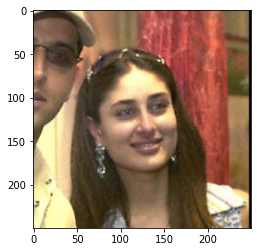

You look like  Chinese crested
Hello, human!


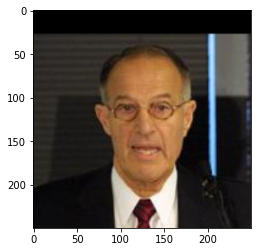

You look like  Basenji
Hello, human!


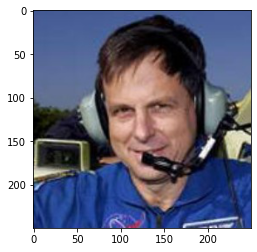

You look like  Dachshund
Hello, dog!


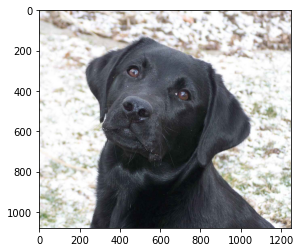

You look like  Flat-coated retriever
Hello, dog!


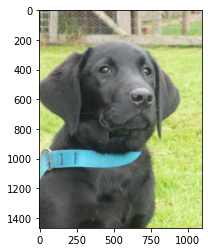

You look like  Flat-coated retriever
Hello, dog!


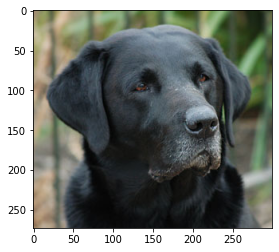

You look like  Flat-coated retriever


In [109]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [122]:
from google.colab import files
files.upload()

Saving img1.jpeg to img1 (1).jpeg
Saving img2.jpeg to img2.jpeg
Saving img3.jpg to img3 (1).jpg
Saving img4.jpg to img4.jpg
Saving img5.jpg to img5.jpg
Saving img6.jpg to img6.jpg


{'img1.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc2\x00\x11\x08\x02\x01\x03\x02\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x00\x07\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\x00\t\n\xff\xc4\x00\x1b\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x00\x03\x04\x05\x06\x07\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xf9

Hello, dog!


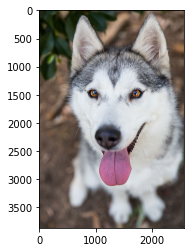

You look like  Alaskan malamute


In [123]:
run_app('img5.jpg')

Hello, dog!


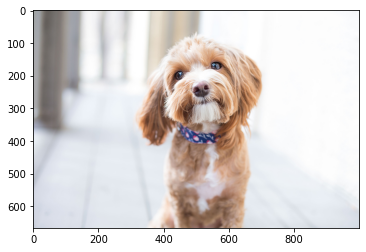

You look like  Havanese


In [124]:
run_app('img6.jpg')

Hello, dog!


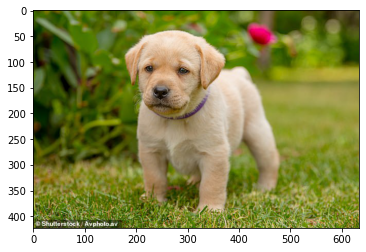

You look like  Golden retriever


In [125]:
run_app('img4.jpg')

Hello, human!


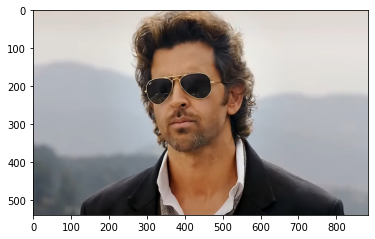

You look like  Dachshund


In [127]:
run_app('img3 (1).jpg')

Hello, human!


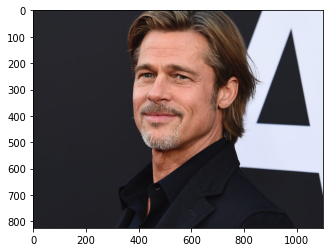

You look like  Cairn terrier


In [128]:
run_app('img2.jpeg')

Hello, human!


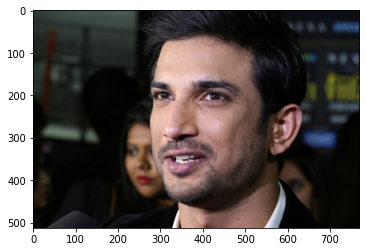

You look like  Bulldog


In [129]:
run_app('img1 (1).jpeg')